# Imports + CUDA

In [1]:
import torch
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name()) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

2.6.0+cu124
12.4
True
NVIDIA GeForce RTX 3070 Laptop GPU
Training on cuda


In [2]:
def show_digit_reconstructions(y: int | str, X: torch.Tensor, model: torch.nn.Module, device: torch.device, n_samples: int = 10):
    """
    Affiche n_samples images du chiffre y, leurs reconstructions et codes latents.
    
    Args:
        y: chiffre à afficher (0-9) ou 'random' pour des chiffres aléatoires
        X: dataset complet
        model: modèle entraîné (MLPAutoencoder ou KANAutoencoder)
        device: device pour les calculs
        n_samples: nombre d'exemples à afficher
    """
    if y == 'random':
        selected_indices = torch.randperm(len(X))[:n_samples]
        title = 'Original (random digits)'
    else:
        digit_indices = (y_train == y).nonzero()[0]
        selected_indices = digit_indices[torch.randperm(len(digit_indices))[:n_samples]]
        title = f'Original (digit {y})'
    
    samples = X[selected_indices]
    
    # Obtenir reconstructions
    model.eval()
    with torch.no_grad():
        # Handle both MLPAutoencoder and KANAutoencoder
        if hasattr(model, 'reconstruct'):
            reconstructions = model.reconstruct(samples.to(device))
            _, latent_codes = model(samples.to(device))
        else:
            reconstructions, latent_codes = model(samples.to(device))
        
        # Déplacer les tenseurs sur CPU avant conversion numpy
        samples = samples.cpu()
        reconstructions = reconstructions.cpu()
        latent_codes = latent_codes.cpu()
    
    # Afficher images originales et reconstructions
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Image originale
        plt.subplot(2, n_samples, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(title)
        
        # Image reconstruite
        plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstruction')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher codes latents
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.bar(range(latent_codes.size(1)), latent_codes[i])
        plt.title(f'Code #{i+1}')
        plt.ylim(-3, 3)
        if i == 0:
            plt.ylabel('Valeur')
        plt.xlabel('Dimension')
    
    plt.tight_layout()
    plt.show()
    
    
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(121)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training metrics if available
    if 'train_metrics' in history and 'val_metrics' in history:
        plt.subplot(122)
        plt.plot(history['train_metrics'], label='Training Metric')
        plt.plot(history['val_metrics'], label='Validation Metric')
        plt.title('Model Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    
def get_mean_latent_factors(digit, X, y, model, device):
    """
    Calcule la moyenne des facteurs latents pour un chiffre donné
    
    Args:
        digit (int): Le chiffre dont on veut la moyenne des facteurs latents (0-9)
        X (torch.Tensor): Dataset MNIST complet
        model: Le modèle d'autoencoder
        device: Device sur lequel faire les calculs (cpu/cuda)
    
    Returns:
        torch.Tensor: Vecteur moyen des facteurs latents pour le chiffre
    """
    # Convertir y en tensor PyTorch
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    # Récupérer les indices des '7' dans le dataset
    digit_indices = torch.where(y_tensor == digit)[0]
    
    # Extraire les images correspondantes
    digit_images = X[digit_indices].to(device)
    
    # Passer dans l'encodeur pour obtenir les facteurs latents
    with torch.no_grad():
        latent_factors = model.encode(digit_images)
    
    # Calculer la moyenne sur tous les exemples
    mean_factors = torch.mean(latent_factors, dim=0)
    
    return mean_factors




In [3]:
from time import sleep

allocated = torch.cuda.memory_allocated()
reserved = torch.cuda.memory_reserved()

torch.cuda.empty_cache()
sleep(1)

print(f"{torch.cuda.memory_allocated()/1024**2:.2f} MB allocated")


0.00 MB allocated


# Load MNIST dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models.ae_kan import KANAutoencoder

train = pd.read_csv("data/MNIST/csv/mnist_train.csv")
test = pd.read_csv("data/MNIST/csv/mnist_test.csv")
print(train.shape, test.shape)

(60000, 785) (10000, 785)


In [5]:
# Préparation des données
y_train = train['label'].values

X = torch.tensor(
    train.drop('label', axis=1).values / 255.0,
    dtype=torch.float32
)   #ne plus mettre sur GPU car je le charge batch par batch ensuite avec DataLoader

print(X.shape)

torch.Size([60000, 784])


# KAN autoencoder

In [ ]:
input_dim = 784  # 28x28 pixels
latent_dim = 32

model = KANAutoencoder(
    input_dim=input_dim,
    k=latent_dim,
    hidden_dims=[128, 64],
    basis_type="spline",
    M=32,  # pour les splines sur la grille
    poly_degree=3,
    dropout_p=0,
    use_silu=True,
    
    lambda_alpha=1e-4,
    lambda_group=1e-5,
    lambda_tv=1e-4,
    lambda_poly_decay=0,
    
    use_skip=True,
    skip_init="identity",
    skip_gain=1.0,
    lambda_skip_l2=0
).to(device)

print(model)
print(f"Nombre total de paramètres: {sum(p.numel() for p in model.parameters()):,}")
print("Architecture:")
print(f"{input_dim} → {' → '.join(map(str, [128, 128]))} → Latent ({latent_dim}) → {' → '.join(map(str, [128, 128]))} → {input_dim}")

KANAutoencoder(
  (encoder_layers): ModuleList(
    (0): KANLayer(
      (basis_1d): HatSpline1D()
      (skip): Linear(in_features=784, out_features=128, bias=False)
    )
    (1): KANLayer(
      (basis_1d): HatSpline1D()
      (skip): Linear(in_features=128, out_features=64, bias=False)
    )
  )
  (encoder_activations): ModuleList(
    (0-1): 2 x SiLU()
  )
  (encoder_dropouts): ModuleList(
    (0): Dropout(p=0, inplace=False)
    (1): Identity()
  )
  (to_latent): Linear(in_features=64, out_features=32, bias=True)
  (from_latent): Linear(in_features=32, out_features=64, bias=True)
  (decoder_layers): ModuleList(
    (0): KANLayer(
      (basis_1d): HatSpline1D()
      (skip): Linear(in_features=64, out_features=128, bias=False)
    )
    (1): KANLayer(
      (basis_1d): HatSpline1D()
      (skip): Linear(in_features=128, out_features=784, bias=False)
    )
  )
  (decoder_activations): ModuleList(
    (0): SiLU()
  )
  (decoder_dropouts): ModuleList(
    (0): Dropout(p=0, inplace=F

In [ ]:
history = model.fit(
    X,
    epochs=30,
    batch_size=512,
    learning_rate=0.01,
    weight_decay=0.00001,
    validation_split=0.2,
    patience=10,
    verbose=True,
    lambda_reg=0.0001
)

🚀 ENTRAÎNEMENT KAN AUTOENCODER (ae_kan)
📊 Données: 48000 train, 12000 val
🏗️  Architecture: 784 -> 128 -> 64 -> 32 -> 64 -> 128 -> 784
🔧 Device: cuda
⚙️  Paramètres: epochs=30, batch_size=512, lr=0.01
🎯 Régularisation: λ=0
🔢 Paramètres: 7,386,292 total, 7,386,292 entraînables
------------------------------------------------------------------------------------------
📈 Époque   1/30 | Train: 0.045047 | Val: 0.029507 ✅ | Reg: 0.000000 | LR: 1.00e-02 | ⏱️  14.8s (ETA: 429.7s)
📈 Époque   2/30 | Train: 0.024240 | Val: 0.021840 ✅ | Reg: 0.000000 | LR: 1.00e-02 | ⏱️  24.8s (ETA: 346.8s)
📈 Époque   3/30 | Train: 0.019466 | Val: 0.017870 ✅ | Reg: 0.000000 | LR: 1.00e-02 | ⏱️  35.0s (ETA: 315.3s)
📈 Époque   4/30 | Train: 0.017285 | Val: 0.017766 ✅ | Reg: 0.000000 | LR: 1.00e-02 | ⏱️  45.2s (ETA: 293.8s)
📈 Époque   5/30 | Train: 0.016224 | Val: 0.015475 ✅ | Reg: 0.000000 | LR: 1.00e-02 | ⏱️  55.6s (ETA: 278.1s)
📈 Époque   6/30 | Train: 0.015523 | Val: 0.016592 ⚠️ | Reg: 0.000000 | LR: 1.00e-02 | ⏱

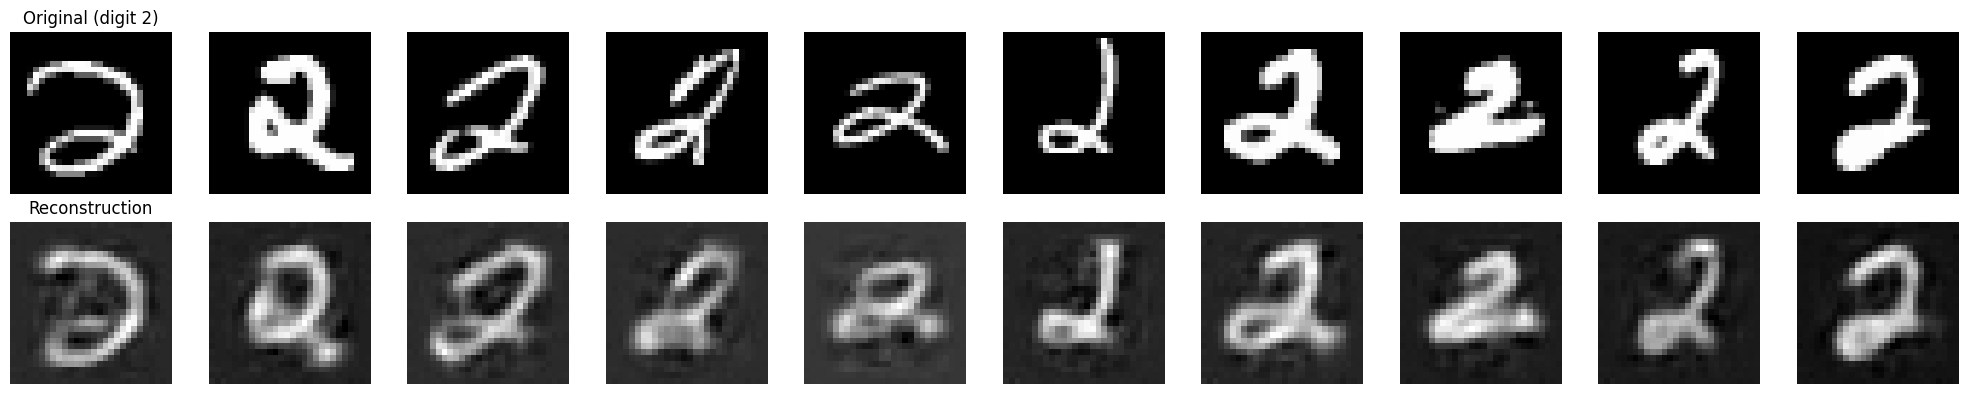

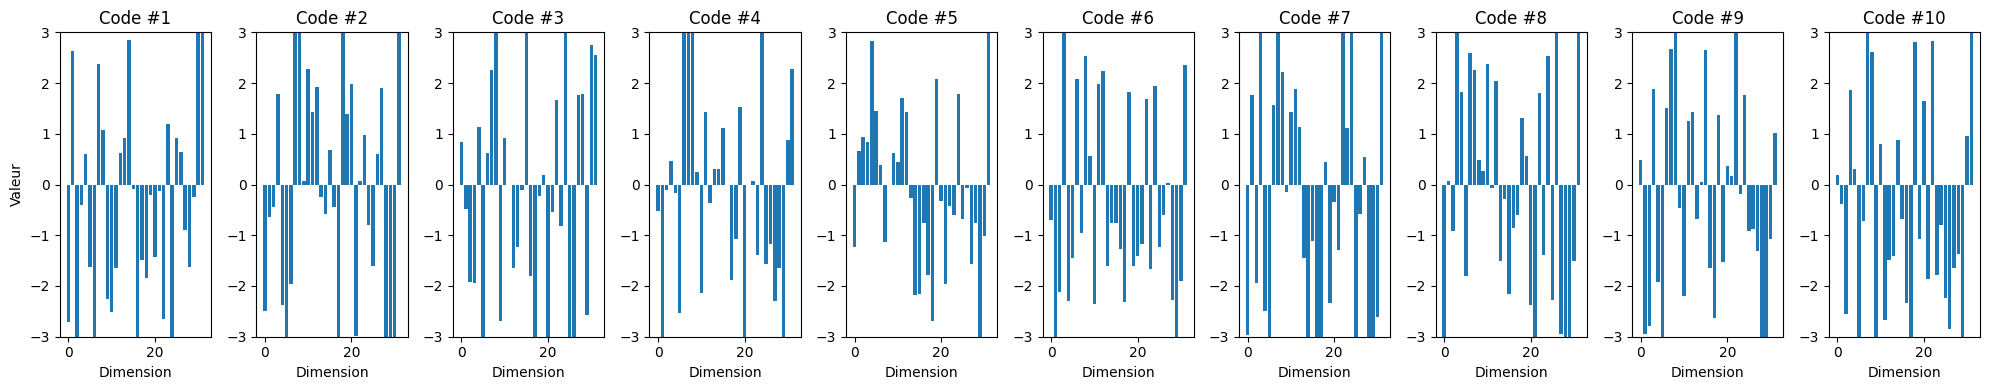

In [8]:
show_digit_reconstructions(y=2, X=X, model=model, device=device)

In [ ]:
import mnist

# Chargement du test set
_, (X_test, y_test) = mnist.load_data()
X_test = X_test.reshape(-1, 784) / 255.0

# Affichage des reconstructions sur le test set
show_digit_reconstructions(y=2, X=X_test, model=model, device=device)

In [23]:
for digit in range(1, 10):
    mean_latent_digit = get_mean_latent_factors(digit=digit, X=X, y=y_train, model=model, device=device).tolist()
    print(digit, mean_latent_digit)

1 [-0.9659807085990906, -1.858632206916809, 1.1760900020599365, 1.0561394691467285, 0.6306774616241455, -0.11659422516822815, -0.3478383421897888, -0.3833235502243042, -1.9463149309158325, 0.7872971892356873, 2.967360258102417, 1.0693119764328003, 0.844700813293457, -0.363410621881485, -0.02369813248515129, 0.7589726448059082, -0.15604455769062042, -2.530264377593994, 2.0211005210876465, -0.10537679493427277, 0.39000579714775085, 1.4248563051223755, -1.19643235206604, -1.1684741973876953, 0.7933211326599121, 2.3556880950927734, -2.072462797164917, 1.0247938632965088, 0.7773569226264954, -0.9484193325042725, -0.9218581914901733, 0.026579851284623146]
2 [-0.7567614316940308, 1.4441461563110352, 0.12758341431617737, -0.43157994747161865, -0.36784160137176514, 0.3587789535522461, -3.7013587951660156, 0.07221533358097076, 0.15059450268745422, 0.021483508870005608, 2.1299831867218018, 0.9120547771453857, 2.82279896736145, -1.6657527685165405, 0.3648908734321594, -0.984061062335968, -0.355236

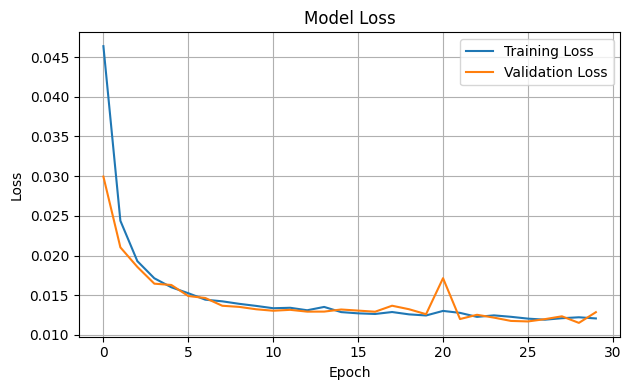

In [19]:
plot_training_history(history)

# Autoencodeur MLP

In [27]:
from src.models.ae_mlp import MLPAutoencoder

mlp_ae = MLPAutoencoder(
    input_dim=784, 
    k=2, 
    hidden=(128, 80), 
    activation="relu", 
    use_bn=False, 
    dropout_p=0.0, 
    loss_type="mse"
    )

In [28]:
# Affichage de l'architecture du modèle
print("🏗️ Architecture de l'autoencodeur MLP:")
print("\nEncodeur:")
print(f"Input ({mlp_ae.input_dim}) → {' → '.join(map(str, mlp_ae.hidden))} → Latent ({mlp_ae.k})")
print("\nDécodeur:")
print(f"Latent ({mlp_ae.k}) → {' → '.join(map(str, mlp_ae.hidden[::-1]))} → Output ({mlp_ae.input_dim})")

# Nombre total de paramètres
total_params = sum(p.numel() for p in mlp_ae.parameters())
trainable_params = sum(p.numel() for p in mlp_ae.parameters() if p.requires_grad)
print(f"\n📊 Paramètres totaux: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")


🏗️ Architecture de l'autoencodeur MLP:

Encodeur:
Input (784) → 128 → 80 → Latent (2)

Décodeur:
Latent (2) → 80 → 128 → Output (784)

📊 Paramètres totaux: 222,706
📊 Paramètres entraînables: 222,706


In [29]:
# Entraînement du modèle MLP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_ae = mlp_ae.to(device)

# Déplacer X sur CPU avant l'entraînement comme requis par fit()
if X.device.type != "cpu":
    X = X.cpu()

print("🚀 Démarrage de l'entraînement...")
hist = mlp_ae.fit(
    X,
    epochs=20,
    batch_size=256,
    learning_rate=1e-3,
    patience=5,
    verbose=True,
    device=device
)

print("✅ Entraînement terminé!")


🚀 Démarrage de l'entraînement...
🚀 ENTRAÎNEMENT MLP AUTOENCODER
📊 Data: 48000 train | 12000 val
🏗️  Arch: 784 -> 128 -> 80 -> 2 -> 80 -> 128 -> 784
⚙️  Params: epochs=20, bs=256, lr=0.001, loss=mse
🔧 Device: cuda | AMP: True
🔢 Paramètres: 222,706 total | 222,706 entraînables
----------------------------------------------------------------------------------------
📈 Époque   1/20 | Train: 0.060829 | Val: 0.052201 ⚠️ | LR: 1.00e-03 | ⏱️ 4.8s (ETA: 91.7s)
📈 Époque   2/20 | Train: 0.049641 | Val: 0.048017 ⚠️ | LR: 1.00e-03 | ⏱️ 6.3s (ETA: 56.3s)
📈 Époque   3/20 | Train: 0.046845 | Val: 0.046232 ⚠️ | LR: 1.00e-03 | ⏱️ 7.7s (ETA: 43.7s)
📈 Époque   4/20 | Train: 0.045469 | Val: 0.045249 ⚠️ | LR: 1.00e-03 | ⏱️ 9.1s (ETA: 36.5s)
📈 Époque   5/20 | Train: 0.044646 | Val: 0.044499 ⚠️ | LR: 1.00e-03 | ⏱️ 10.4s (ETA: 31.3s)
📈 Époque   6/20 | Train: 0.043941 | Val: 0.044036 ⚠️ | LR: 1.00e-03 | ⏱️ 11.8s (ETA: 27.5s)
📈 Époque   7/20 | Train: 0.043440 | Val: 0.043635 ⚠️ | LR: 1.00e-03 | ⏱️ 13.1s (ETA: 24

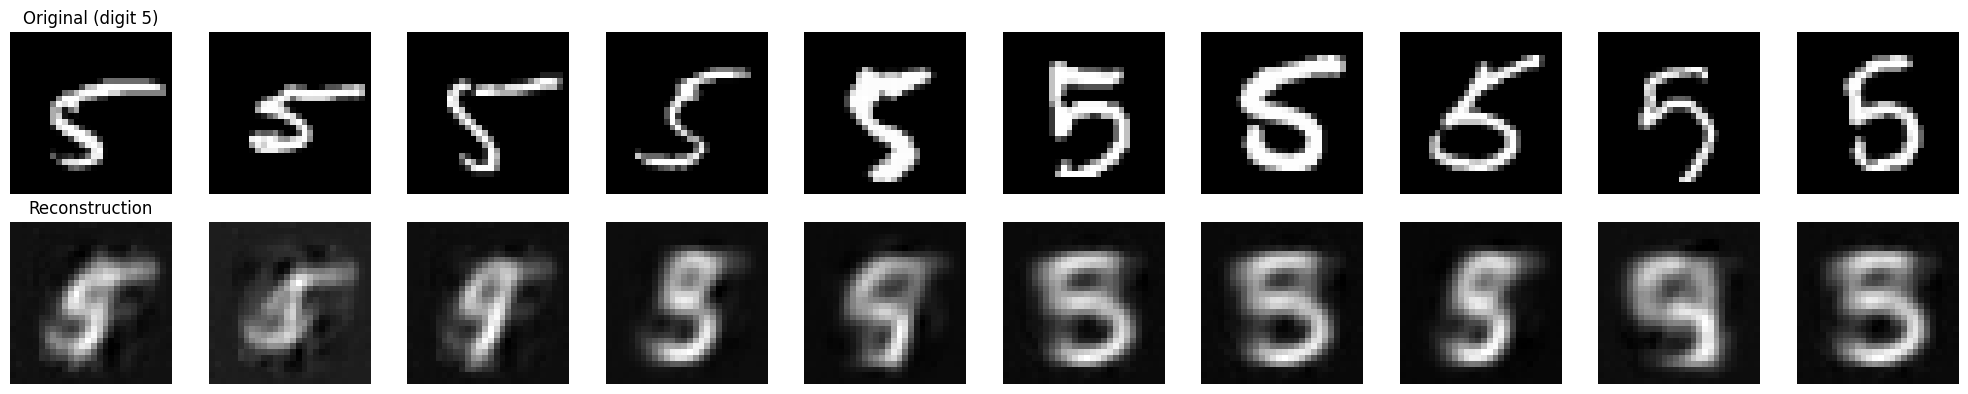

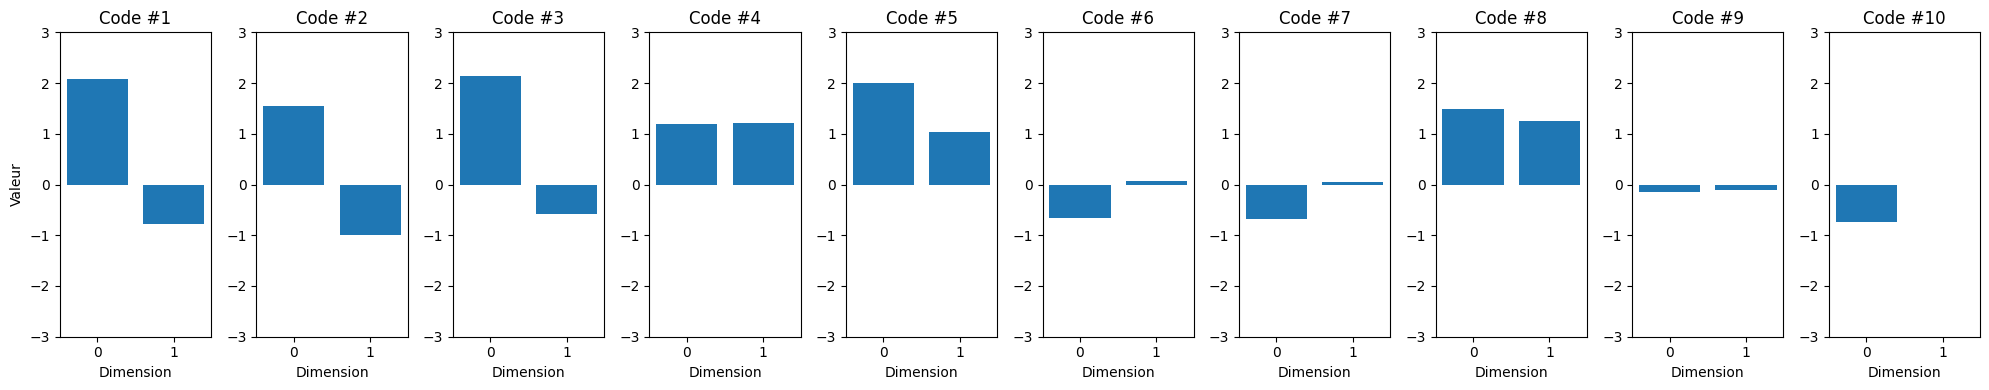

In [72]:
show_digit_reconstructions(y=5, X=X, model=mlp_ae, device=device)